## Understanding word vectors

reference: https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

In this tutorial, I'm going to show you how word vectors work. This tutorial assumes a good amount of Python knowledge, but even if you're not a Python expert, you should be able to follow along and make small changes to the examples without too much trouble.

This is a "Jupyter Notebook," which consists of text and "cells" of code. After you've loaded the notebook, you can execute the code in a cell by highlighting it and hitting Ctrl+Enter. In general, you need to execute the cells from top to bottom, but you can usually run a cell more than once without messing anything up. Experiment!

If things start acting strange, you can interrupt the Python process by selecting "Kernel > Interrupt"—this tells Python to stop doing whatever it was doing. Select "Kernel > Restart" to clear all of your variables and start from scratch.

## why word vector

Poetry is, at its core, the art of identifying and manipulating linguistic similarity. I have discovered a truly marvelous proof of this, which this notebook is too narrow to contain. (By which I mean: I will elaborate on this some other time)

Animal similarity and simple linear algebra

## Animal similarity and simple linear algebra

We'll begin by considering a small subset of English: words for animals. Our task is to be able to write computer programs to find similarities among these words and the creatures they designate. To do this, we might start by making a spreadsheet of some animals and their characteristics. For example:
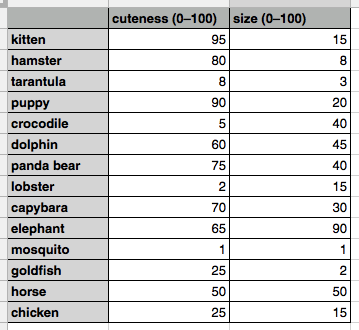
This spreadsheet associates a handful of animals with two numbers: their cuteness and their size, both in a range from zero to one hundred. (The values themselves are simply based on my own judgment. Your taste in cuteness and evaluation of size may differ significantly from mine. As with all data, these data are simply a mirror reflection of the person who collected them.)

In [1]:
import math
def distance2d(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

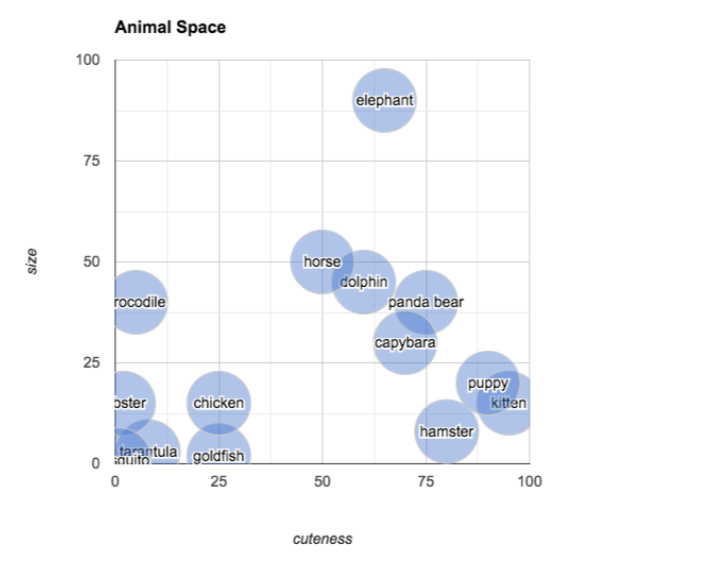
So, the distance between "capybara" (70, 30) and "panda" (74, 40):

In [2]:
distance2d(70, 30, 75, 40)

11.180339887498949

Modeling animals in this way has a few other interesting properties. For example, you can pick an arbitrary point in "animal space" and then find the animal closest to that point. If you imagine an animal of size 25 and cuteness 30, you can easily look at the space to find the animal that most closely fits that description: the chicken.

Reasoning visually, you can also answer questions like: what's halfway between a chicken and an elephant? Simply draw a line from "elephant" to "chicken," mark off the midpoint and find the closest animal. (According to our chart, halfway between an elephant and a chicken is a horse.)

You can also ask: what's the difference between a hamster and a tarantula? According to our plot, it's about seventy five units of cute (and a few units of size).

The relationship of "difference" is an interesting one, because it allows us to reason about analogous relationships. In the chart below, I've drawn an arrow from "tarantula" to "hamster" (in blue):

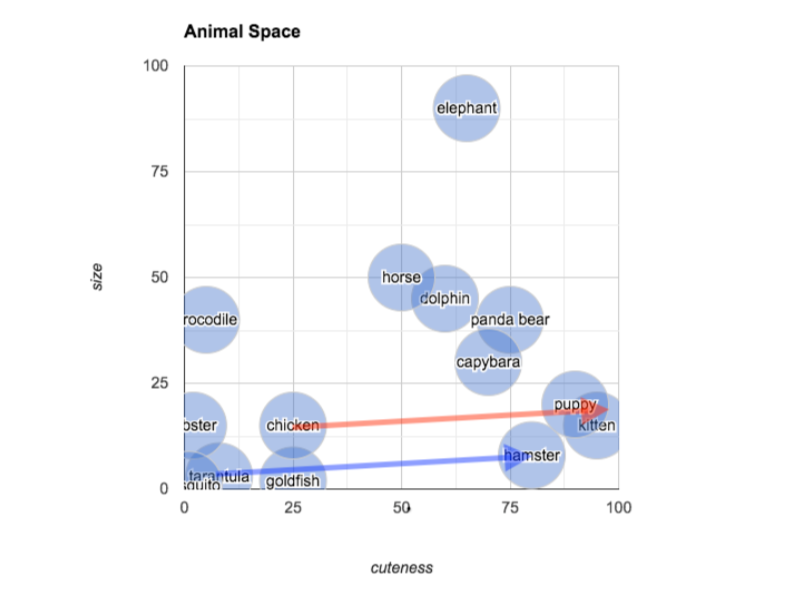

## Language with vectors: colors
So far, so good. We have a system in place—albeit highly subjective—for talking about animals and the words used to name them. I want to talk about another vector space that has to do with language: the vector space of colors.

Colors are often represented in computers as vectors with three dimensions: red, green, and blue. Just as with the animals in the previous section, we can use these vectors to answer questions like: which colors are similar? What's the most likely color name for an arbitrarily chosen set of values for red, green and blue? Given the names of two colors, what's the name of those colors' "average"?

We'll be working with this color data from the xkcd color survey. The data relates a color name to the RGB value associated with that color. Here's a page that shows what the colors look like. Download the color data and put it in the same directory as this notebook.

A few notes before we proceed:

1. The linear algebra functions implemented below (addv, meanv, etc.) are slow, potentially inaccurate, and shouldn't be used for "real" code—I wrote them so beginner programmers can understand how these kinds of functions work behind the scenes. Use numpy for fast and accurate math in Python.

2. If you're interested in perceptually accurate color math in Python, consider using the colormath library.

Now, import the json library and load the color data:

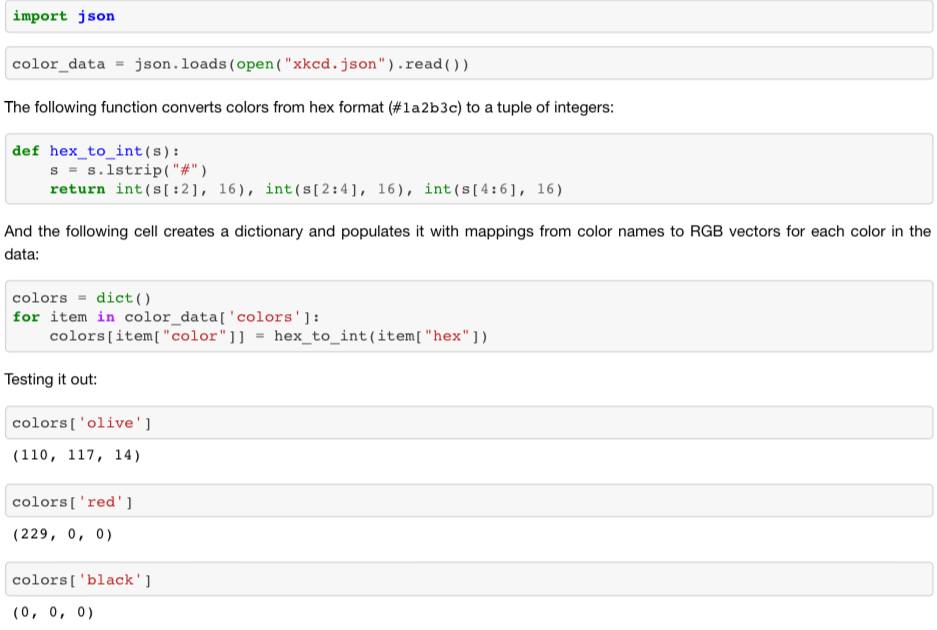

## vector math

Before we keep going, we'll need some functions for performing basic vector "arithmetic." These functions will work with vectors in spaces of any number of dimensions.

In [3]:
import math
def distance(coord1, coord2):
    # note, this is VERY SLOW, don't use for actual code
    return math.sqrt(sum([(i - j)**2 for i, j in zip(coord1, coord2)]))
distance([10, 1], [5, 2])

5.0990195135927845

In [4]:
# The subtractv function subtracts one vector from another:
def subtractv(coord1, coord2):
    return [c1 - c2 for c1, c2 in zip(coord1, coord2)]
subtractv([10, 1], [5, 2])

[5, -1]

In [5]:
# The addv vector adds two vectors together:

def addv(coord1, coord2):
    return [c1 + c2 for c1, c2 in zip(coord1, coord2)]
addv([10, 1], [5, 2])

[15, 3]

In [6]:
# And the meanv function takes a list of vectors and finds their mean or average:
def meanv(coords):
    # assumes every item in coords has same length as item 0
    sumv = [0] * len(coords[0])
    for item in coords:
        for i in range(len(item)):
            sumv[i] += item[i]
    mean = [0] * len(sumv)
    for i in range(len(sumv)):
        mean[i] = float(sumv[i]) / len(coords)
    return mean
meanv([[0, 1], [2, 2], [4, 3]])

[2.0, 2.0]

## find the closest item

Just as we wanted to find the animal that most closely matched an arbitrary point in cuteness/size space, we'll want to find the closest color name to an arbitrary point in RGB space. The easiest way to find the closest item to an arbitrary vector is simply to find the distance between the target vector and each item in the space, in turn, then sort the list from closest to farthest. The closest() function below does just that. By default, it returns a list of the ten closest items to the given vector.

Note: Calculating "closest neighbors" like this is fine for the examples in this notebook, but unmanageably slow for vector spaces of any appreciable size. As your vector space grows, you'll want to move to a faster solution, like SciPy's kdtree or Annoy.

正如我们想要找到最接近于可爱度/大小空间中任意点的动物一样，我们也希望找到与RGB空间中任意点最接近的颜色名称。 找到与任意向量最接近的项的最简单方法是，依次找到目标向量与空间中每个项之间的距离，然后从最接近到最远对列表进行排序。 下面最接近的（）函数就是这样做的。 默认情况下，它将返回与给定向量最接近的十个项目的列表。

In [7]:
import json
color_data = json.loads(open("xkcd.json").read())

In [8]:
# The following function converts colors from hex format (#1a2b3c) to a tuple of integers:
def hex_to_int(s):
    s = s.lstrip("#")
    return int(s[:2], 16), int(s[2:4], 16), int(s[4:6], 16)

# And the following cell creates a dictionary and populates it with mappings from color names to RGB vectors for each color in the data:
colors = dict()
for item in color_data['colors']:
    colors[item["color"]] = hex_to_int(item["hex"])

In [9]:
colors['olive']

(110, 117, 14)

In [10]:
def closest(space, coord, n=10):
    closest = []
    for key in sorted(space.keys(),
                        key=lambda x: distance(coord, space[x]))[:n]:
        closest.append(key)
    return closest


In [11]:
closest(colors, colors['red'])

['red',
 'fire engine red',
 'bright red',
 'tomato red',
 'cherry red',
 'scarlet',
 'vermillion',
 'orangish red',
 'cherry',
 'lipstick red']

.. or the ten colors closest to (150, 60, 150):

In [12]:
closest(colors, [150, 60, 150])

['warm purple',
 'medium purple',
 'ugly purple',
 'light eggplant',
 'purpleish',
 'purplish',
 'purply',
 'light plum',
 'purple',
 'muted purple']

将单词表示为向量的神奇之处在于，我们前面定义的向量运算似乎在语言上运算的方式与在数字上运算的方式相同。 例如，如果我们发现最接近向量的词是从“紫色”中减去“红色”而得到的，则会得到一系列“蓝色”颜色：

The magical part of representing words as vectors is that the vector operations we defined earlier appear to operate on language the same way they operate on numbers. For example, if we find the word closest to the vector resulting from subtracting "red" from "purple," we get a series of "blue" colors:

In [13]:
closest(colors, subtractv(colors['purple'], colors['red']))

['cobalt blue',
 'royal blue',
 'darkish blue',
 'true blue',
 'royal',
 'prussian blue',
 'dark royal blue',
 'deep blue',
 'marine blue',
 'deep sea blue']

In [14]:
closest(colors, addv(colors['blue'], colors['green']))

['bright turquoise',
 'bright light blue',
 'bright aqua',
 'cyan',
 'neon blue',
 'aqua blue',
 'bright cyan',
 'bright sky blue',
 'aqua',
 'bright teal']

In [15]:
# the average of black and white: medium grey
closest(colors, meanv([colors['black'], colors['white']]))

['medium grey',
 'purple grey',
 'steel grey',
 'battleship grey',
 'grey purple',
 'purplish grey',
 'greyish purple',
 'steel',
 'warm grey',
 'green grey']

In [16]:
# an analogy: pink is to red as X is to blue
pink_to_red = subtractv(colors['pink'], colors['red'])
closest(colors, addv(pink_to_red, colors['blue']))

['neon blue',
 'bright sky blue',
 'bright light blue',
 'cyan',
 'bright cyan',
 'bright turquoise',
 'clear blue',
 'azure',
 'dodger blue',
 'lightish blue']

In [17]:
# another example: 
navy_to_blue = subtractv(colors['navy'], colors['blue'])
closest(colors, addv(navy_to_blue, colors['green']))

['true green',
 'dark grass green',
 'grassy green',
 'racing green',
 'forest',
 'bottle green',
 'dark olive green',
 'darkgreen',
 'forrest green',
 'grass green']

The examples above are fairly simple from a mathematical perspective but nevertheless feel magical: they're demonstrating that it's possible to use math to reason about how people use language.

## Doing bad digital humanities with color vectors

With the tools above in hand, we can start using our vectorized knowledge of language toward academic ends. In the following example, I'm going to calculate the average color of Bram Stoker's Dracula.

(Before you proceed, make sure to download the text file from Project Gutenberg and place it in the same directory as this notebook.)

First, we'll load spaCy:

In [18]:
import spacy

In [19]:
nlp = spacy.load('en_core_web_sm')


To calculate the average color, we'll follow these steps:

1. Parse the text into words
2. Check every word to see if it names a color in our vector space. If it does, add it to a list of vectors.
3. Find the average of that list of vectors.
4. Find the color(s) closest to that average vector.

The following cell performs steps 1-3:

In [ ]:
doc = nlp(open("pg345.txt").read())
# use word.lower_ to normalize case
drac_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(drac_colors)
print(avg_color)

Now, we'll pass the averaged color vector to the closest() function, yielding... well, it's just a brown mush, which is kinda what you'd expect from adding a bunch of colors together willy-nilly.

In [ ]:
closest(colors, avg_color)

In [ ]:
doc = nlp(open("pg1952.txt").read())
wallpaper_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(wallpaper_colors)
closest(colors, avg_color)

In [ ]:
for cname in closest(colors, colors['mauve']):
    print(cname + " trousers")

That's all well and good for color words, which intuitively seem to exist in a multidimensional continuum of perception, and for our animal space, where we've written out the vectors ahead of time. But what about... arbitrary words? Is it possible to create a vector space for all English words that has this same "closer in space is closer in meaning" property?

To answer that, we have to back up a bit and ask the question: what does meaning mean? No one really knows, but one theory popular among computational linguists, computer scientists and other people who make search engines is the Distributional Hypothesis, which states that:

    Linguistic items with similar distributions have similar meanings.
    
What's meant by "similar distributions" is similar contexts. Take for example the following sentences:

    It was really cold yesterday.
    It will be really warm today, though.
    It'll be really hot tomorrow!
    Will it be really cool Tuesday?

According to the Distributional Hypothesis, the words cold, warm, hot and cool must be related in some way (i.e., be close in meaning) because they occur in a similar context, i.e., between the word "really" and a word indicating a particular day. (Likewise, the words yesterday, today, tomorrow and Tuesday must be related, since they occur in the context of a word indicating a temperature.)

In other words, according to the Distributional Hypothesis, a word's meaning is just a big list of all the contexts it occurs in. Two words are closer in meaning if they share contexts.

根据分布假说，冷，暖，热和凉这两个词必须以某种方式关联（即，含义相近），因为它们出现在相似的上下文中，即在“真正”一词和表示“真实”的词之间 特定的一天。 （同样，昨天，今天，明天和星期二这两个词必须相关，因为它们出现在表示温度的词的上下文中。）

换句话说，根据分布假说，一个单词的含义只是其出现的所有上下文的一个大列表。如果两个单词共享上下文，则两个单词的含义更接近。

## Word vectors by counting contexts

So how do we turn this insight from the Distributional Hypothesis into a system for creating general-purpose vectors that capture the meaning of words? Maybe you can see where I'm going with this. What if we made a really big spreadsheet that had one column for every context for every word in a given source text. Let's use a small source text to begin with, such as this excerpt from Dickens:

It was the best of times, it was the worst of times.

    Such a spreadsheet might look something like this:
 
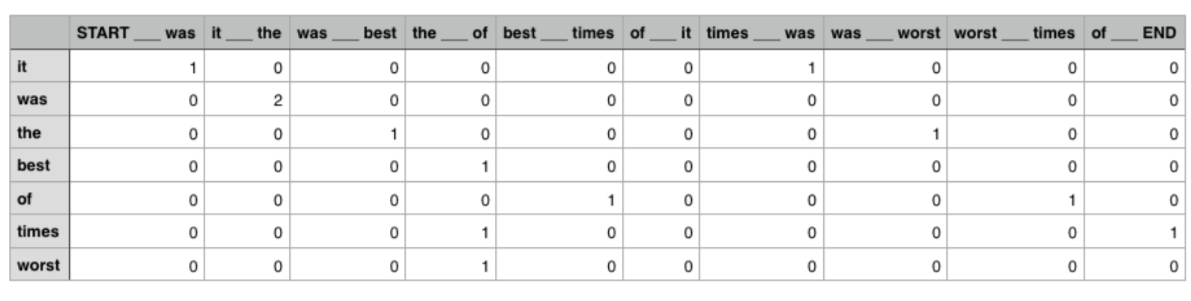

The spreadsheet has one column for every possible context, and one row for every word. The values in each cell correspond with how many times the word occurs in the given context. The numbers in the columns constitute that word's vector, i.e., the vector for the word of is

    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

Because there are ten possible contexts, this is a ten dimensional space! It might be strange to think of it, but you can do vector arithmetic on vectors with ten dimensions just as easily as you can on vectors with two or three dimensions, and you could use the same distance formula that we defined earlier to get useful information about which vectors in this space are similar to each other. In particular, the vectors for best and worst are actually the same (a distance of zero), since they occur only in the same context (the ___ of):

    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

Of course, the conventional way of thinking about "best" and "worst" is that they're antonyms, not synonyms. But they're also clearly two words of the same kind, with related meanings (through opposition), a fact that is captured by this distributional model.

## Contexts and dimensionality

Of course, in a corpus of any reasonable size, there will be many thousands if not many millions of possible contexts. It's difficult enough working with a vector space of ten dimensions, let alone a vector space of a million dimensions! It turns out, though, that many of the dimensions end up being superfluous and can either be eliminated or combined with other dimensions without significantly affecting the predictive power of the resulting vectors. The process of getting rid of superfluous dimensions in a vector space is called dimensionality reduction, and most implementations of count-based word vectors make use of dimensionality reduction so that the resulting vector space has a reasonable number of dimensions (say, 100—300, depending on the corpus and application).

The question of how to identify a "context" is itself very difficult to answer. In the toy example above, we've said that a "context" is just the word that precedes and the word that follows. Depending on your implementation of this procedure, though, you might want a context with a bigger "window" (e.g., two words before and after), or a non-contiguous window (skip a word before and after the given word). You might exclude certain "function" words like "the" and "of" when determining a word's context, or you might lemmatize the words before you begin your analysis, so two occurrences with different "forms" of the same word count as the same context. These are all questions open to research and debate, and different implementations of procedures for creating count-based word vectors make different decisions on this issue.



## Word vectors in spaCy

Okay, let's have some fun with real word vectors. We're going to use the GloVe vectors that come with spaCy to creatively analyze and manipulate the text of Bram Stoker's Dracula. First, make sure you've got spacy imported:

In [ ]:
from __future__ import unicode_literals
import spacy

In [ ]:
# the following cell loads the language model and parses the input text

nlp = spacy.load('en_core_web_sm')
doc = nlp(open("pg345.txt").read())

In [ ]:
# And the cell below creates a list of unique words (or tokens) in the text, as a list of strings.
# All of the words in the text file

tokens = list(set([w.text for w in doc if w.is_alpha]))
tokens

In [ ]:
def vec(s):
    return nlp.vocab[s].vector

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [ ]:
# cosine similarity
def cosine(v1, v2):
    if norm(v1) > 0 and norm(v2) > 0:
        return dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0

In [ ]:
cosine(vec('dog'), vec('puppy')) > cosine(vec('trousers'), vec('octopus'))